In [1]:
data_path = '/home/sthomas/projects/sensitivity_analysis'

In [2]:
import os
os.environ['MATPLOTLIBRC'] = "../../matplotlibrc" 
import signac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from scipy.signal import argrelextrema as argex
import matplotlib.cm as cm
import itertools
from common import *
            
names={'iso':'Isothermal','lin_ramp':'Linear Ramp','step':'Step'}
colors={'iso':'C0','lin_ramp':'C1','step':'C2'}
markers={'iso':'s','lin_ramp':'P','step':'>'}
linestyles={'iso':'-','lin_ramp':'--','step':'-.'}

def init_project():
    df_index = pd.DataFrame(project.index())
    df_index = df_index.set_index(['_id'])
    statepoints = {doc['_id']: doc['statepoint'] for doc in project.index()}
    #print(statepoints)
    df = pd.DataFrame(statepoints).T.join(df_index)
    df = df.sort_values('T')
    return df
project = signac.get_project(data_path)
df = init_project()

In [3]:
df_filtered = df[(df.activation_energy==3.0)&
                  (df.stop_after_percent==100.0)&
                 (df.profile=='ramp_up_and_down')]
df['t1'] = df_filtered['temp_prof'].str[1].str[0]
df['t2'] = df_filtered['temp_prof'].str[3].str[0]

In [4]:
df_filtered = df[(df.activation_energy==3.0)&
                  (df.stop_after_percent==100.0)&
                 (df.profile=='step_SA')]
df['t1'] = df_filtered['temp_prof'].str[1].str[0]
df_sorted = df.sort_values('t1')

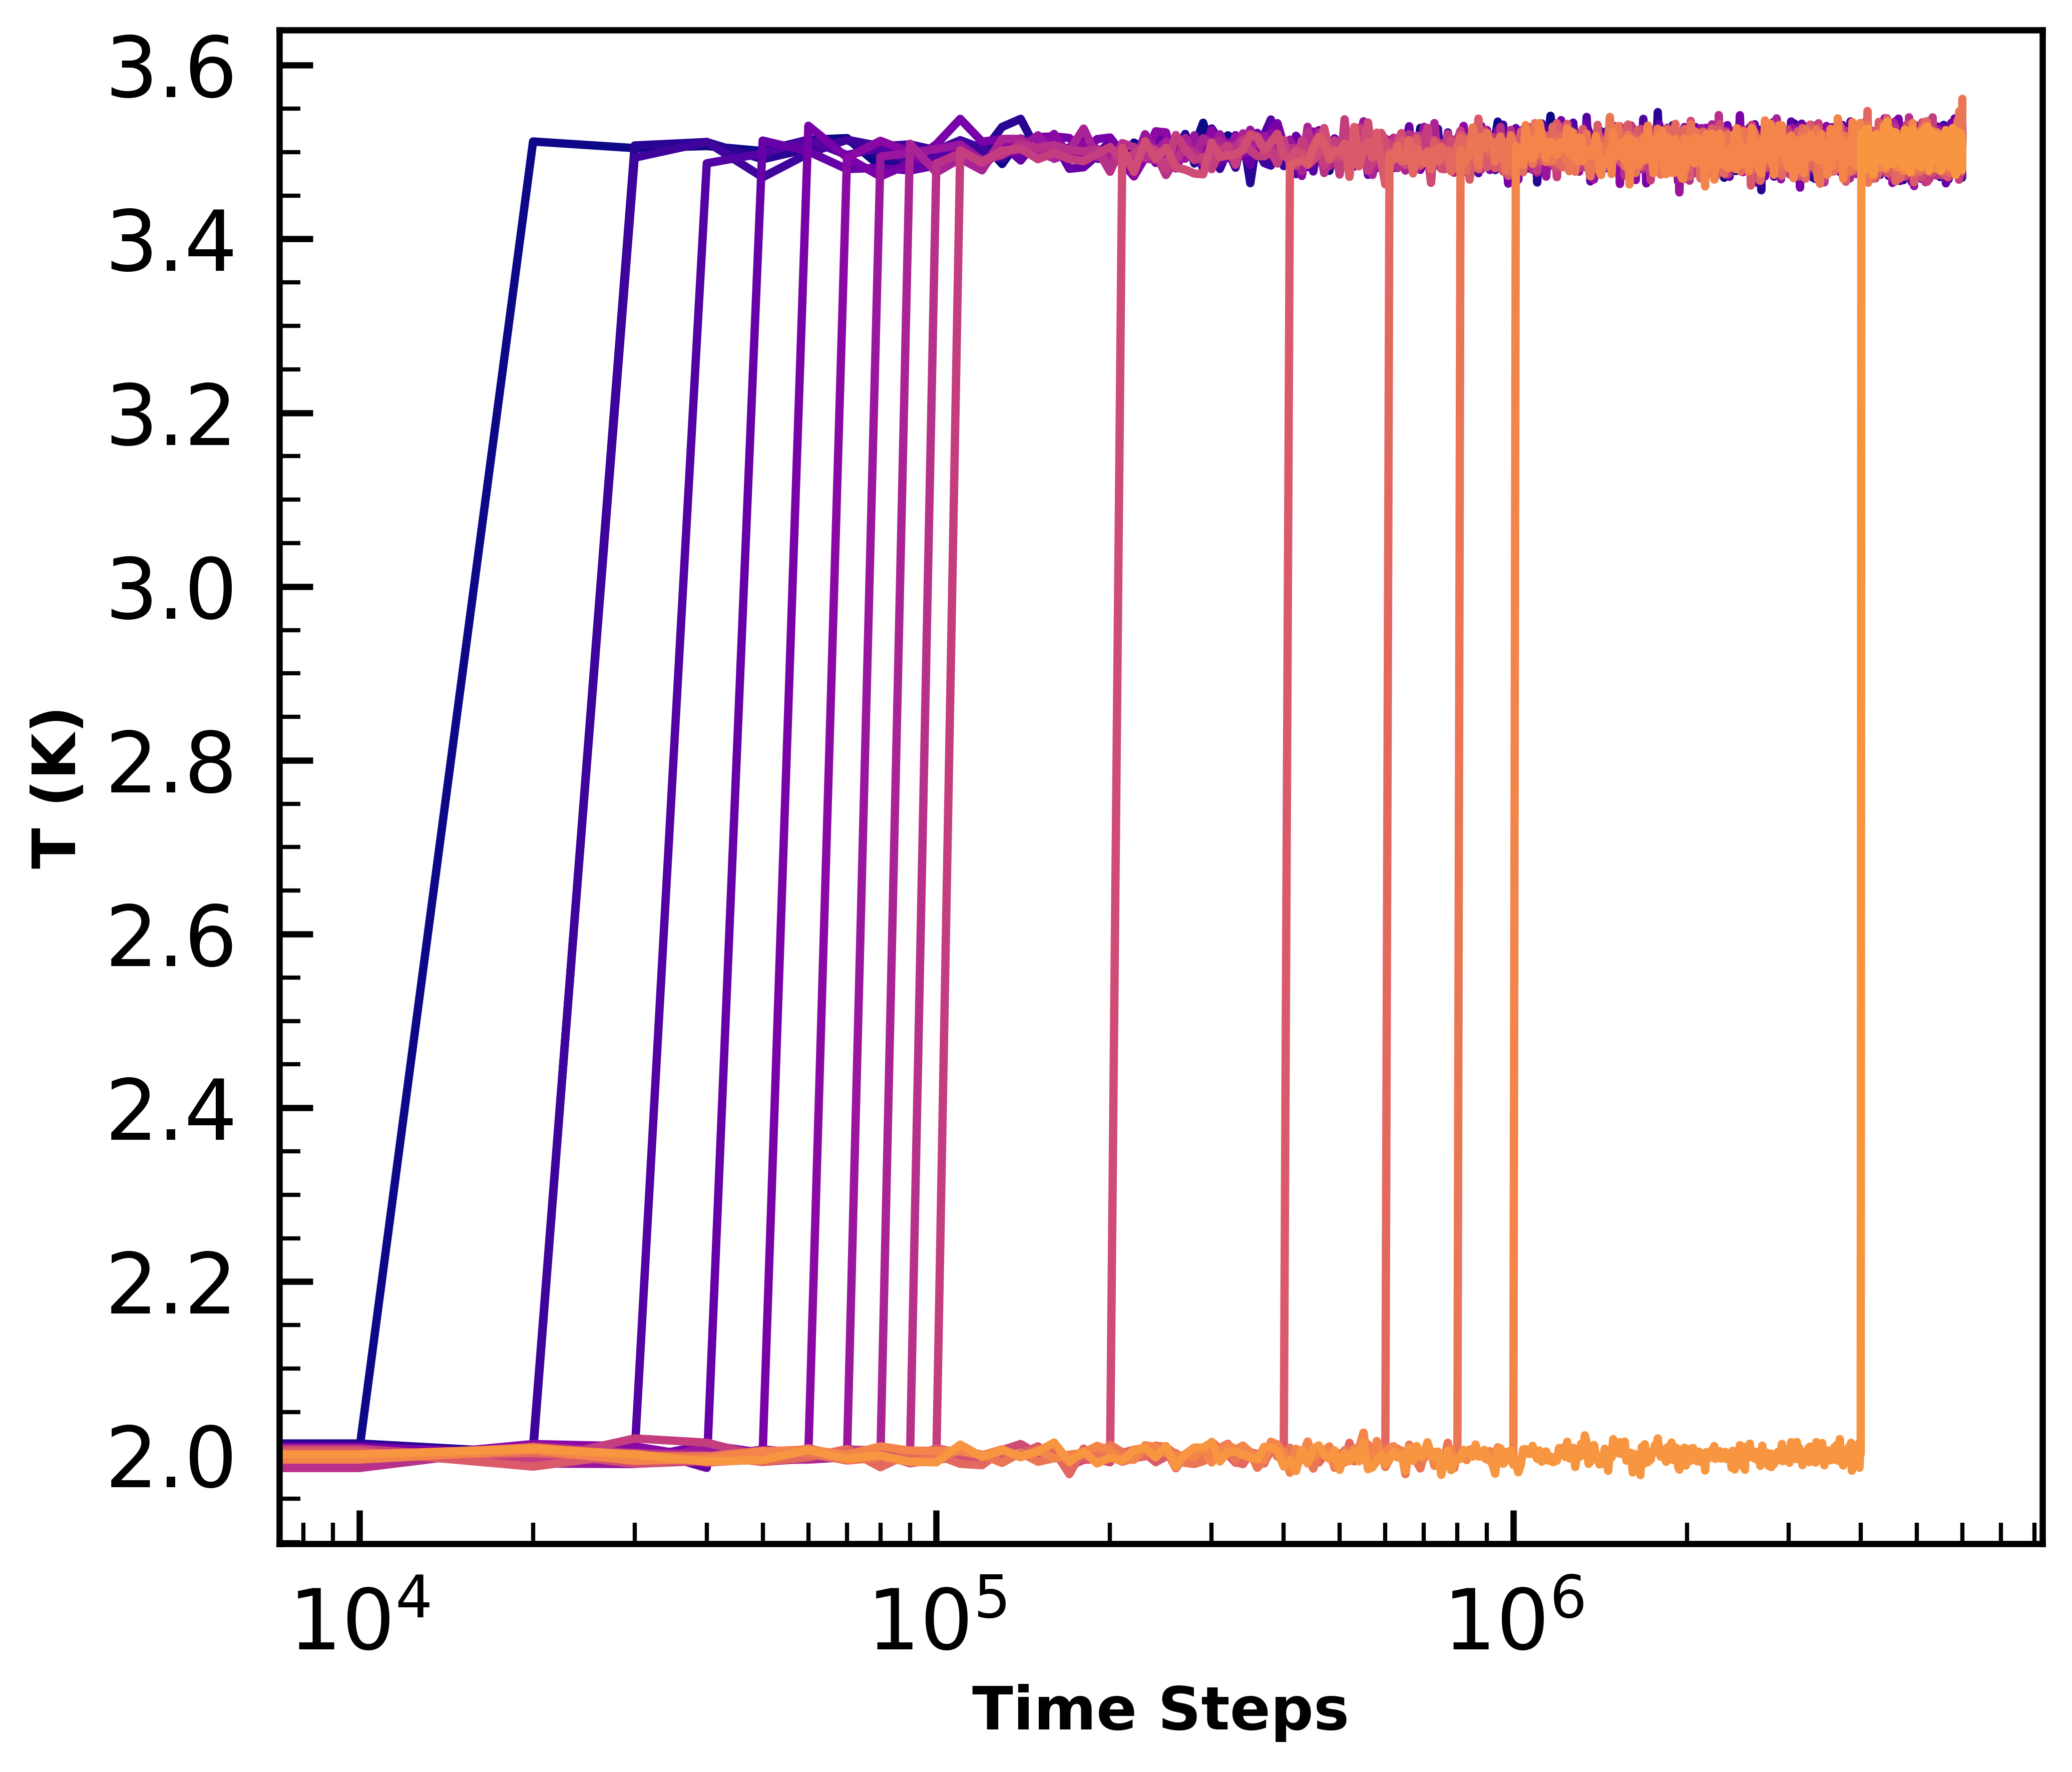

In [5]:
fig = plt.figure(dpi=600, figsize=(7, 6))
ax1 = fig.add_subplot(111)
lines=[]
time_conversion = 1.05e-11 #s
distance_conversion = 1.06 #nm
TemperatureConversion = 365.01 #K
df_filtered = df[(df.activation_energy==3.0)&
                (df.stop_after_percent==100.0)&
                (df.profile=='step_SA')]
colors = plt.cm.plasma(np.linspace(0,0.75,len(df_filtered.groupby('t1'))))
for i,(key,dfgrp) in enumerate(df_filtered.groupby('t1')):
    for jobid in dfgrp.index:
        job=project.open_job(id=jobid)
        data = np.genfromtxt(job.fn('out.log'),names=True)
        ax1.plot(data['timestep'],
                 data['temperature'],#*TemperatureConversion,
                 linewidth=2.0,
                color=colors[i])
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('T (K)')
plt.xscale('log')
plt.savefig("temperature_profiles.png", transparent=True)
plt.show()   

15000.0 940000.0
20000.0 940000.0
25000.0 940000.0
35000.0 940000.0
45000.0 940000.0
55000.0 940000.0
65000.0 940000.0
75000.0 940000.0
85000.0 940000.0
95000.0 940000.0
105000.0 940000.0
205000.0 940000.0
405000.0 1260000.0
605000.0 1260000.0
805000.0 1560000.0
1005000.0 1560000.0
4005000.0 2840000.0


<ipython-input-6-a1eb2e2caeda>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("gel_points.png", transparent=True)
/home/mikehenry/miniconda3/envs/tg-plots/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


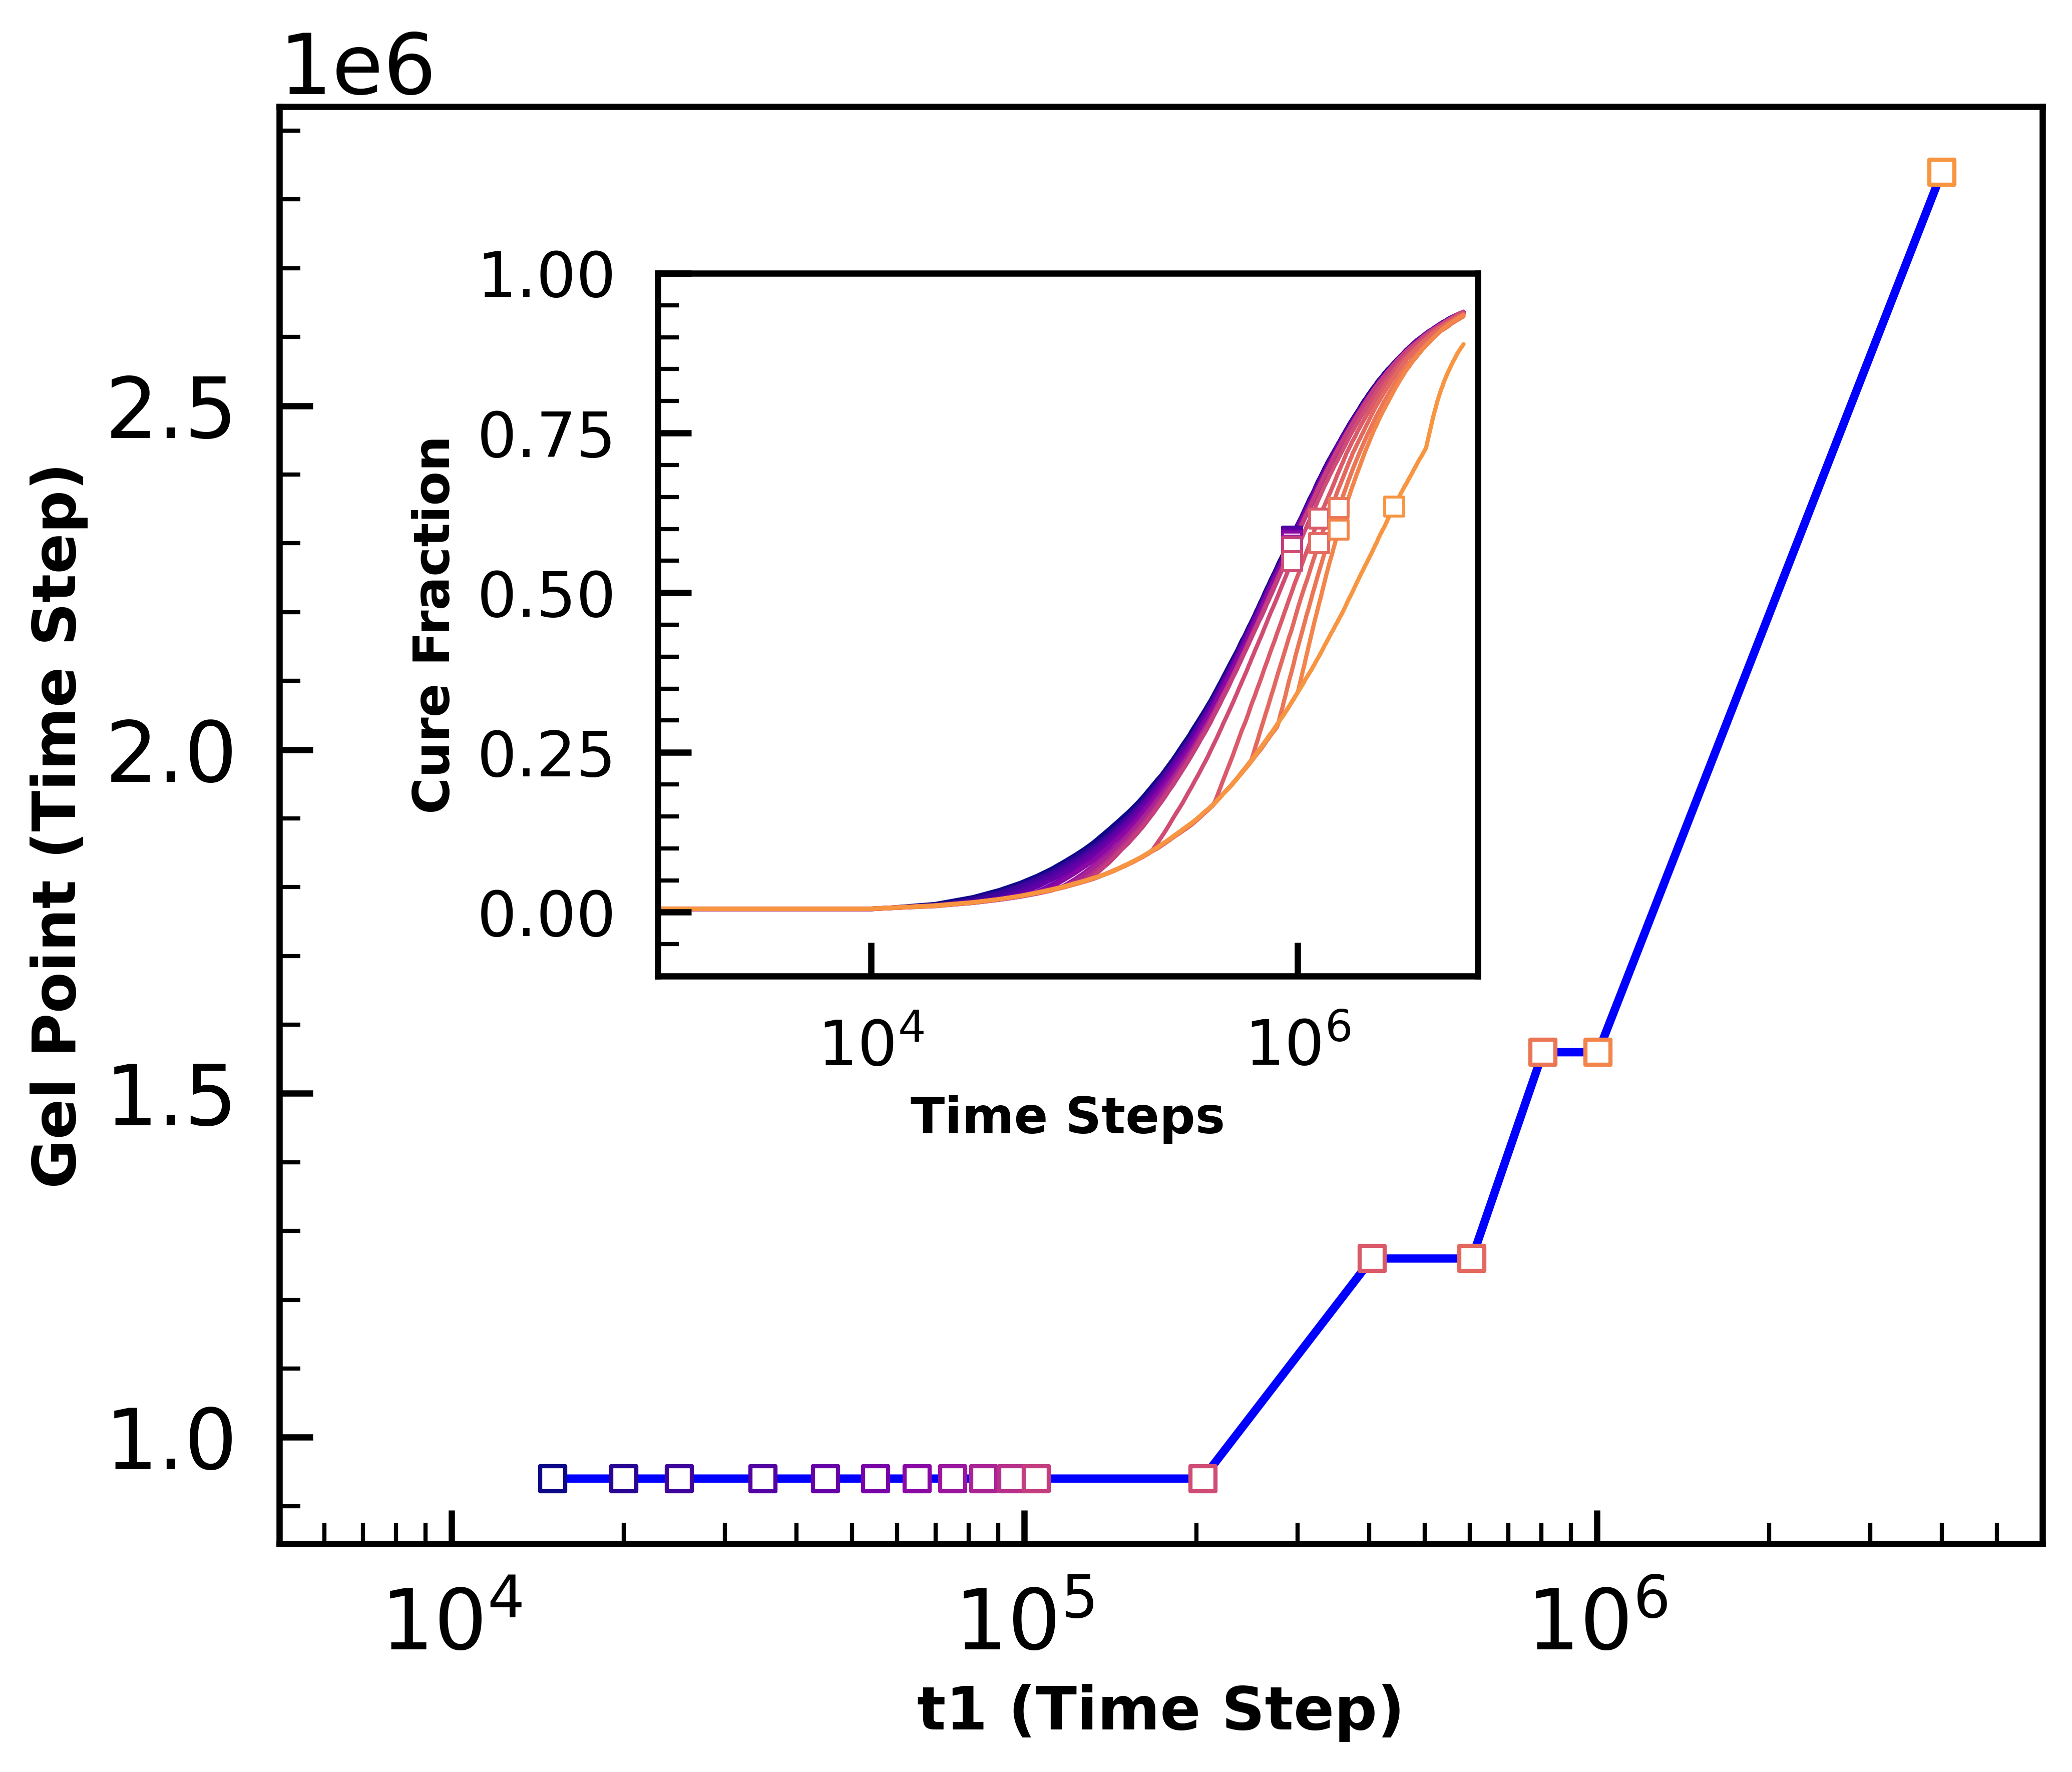

In [6]:
fig = plt.figure(dpi=600, figsize=(7, 6))
ax1 = fig.add_subplot(111) 
gel_points=[]
ramp_up_times=[]
# These are in unitless percentages of the figure size. (0,0 is bottom left)

df_filtered = df[(df.activation_energy==3.0)&
                 (df.stop_after_percent==100.0)&
                 (df.profile=='step_SA')]
colors = plt.cm.plasma(np.linspace(0,0.75,len(df_filtered.groupby('t1'))))
for i,(key,dfgrp) in enumerate(df_filtered.groupby('t1')):
    for jobid in dfgrp.index:
        job=project.open_job(id=jobid)
        x=job.document['gel_point']
        gel_points.append(x)
        ramp_up_times.append(key)
        print(key,job.document['gel_point'])
        ax1.scatter(key,
                    job.document['gel_point'],
                   marker='s',
                    facecolor='w',
                    linewidth=1.0,
                    color=colors[i],
                   zorder=1)
ax1.plot(ramp_up_times,
         gel_points,
         color='b',
         linewidth=2.0,
        label='Gel Point',
        zorder=0)
#print(ramp_up_times)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax1.set_xlabel('t1 (Time Step)')
ax1.set_ylabel('Gel Point (Time Step)')
ax1.set_xscale('log')
ax1.set_xlim(5e3,6e6)

left, bottom, width, height = [0.32, 0.45, 0.39, 0.39]
ax2 = fig.add_axes([left, bottom, width, height])
colors = plt.cm.plasma(np.linspace(0,0.75,len(df_filtered.groupby('t1'))))
for i,(key,dfgrp) in enumerate(df_filtered.groupby('t1')):
    for jobid in dfgrp.index:
        job=project.open_job(id=jobid)
        data = np.genfromtxt(job.fn('out.log'),names=True)
        ax2.plot(data['timestep'],
                 data['bond_percentAB']/100,
                 label='t1: {:.1e}'.format(key),
                 color=colors[i],
                 linewidth=1.0,
                zorder=0)
        ax2.scatter(job.document['gel_point'],
                   job.document['curing_at_gel_point']/100,
                    marker='s',
                    facecolor='w',
                    linewidth=0.7,
                    s=20,
                    color=colors[i],
                   zorder=1)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax2.set_ylim(-0.1,1)
ax2.set_xlim(1e3,7e6)
ax2.set_xlabel('Time Steps',fontsize=12.0)
ax2.set_ylabel('Cure Fraction',fontsize=12.0)
ax2.set_xscale('log')
plt.savefig("gel_points.png", transparent=True)
plt.show()   